# <h1 align=center>***PROYECTO INDIVIDUAL: MLOPs Darío Aveiro*** </h1>



Importaremos las librerías para poder leer, graficar y abrir los archivos con los cuales vamos a trabajar a lo largo del proyecto.

In [3]:
import json
import pandas as pd
import gzip
import ast
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from collections import Counter
import random
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.colab import files
from ast import literal_eval
import os
import ast
import shutil
from datetime import datetime
%load_ext autoreload
import warnings
warnings.filterwarnings("ignore")
import csv
from sklearn.metrics.pairwise import cosine_similarity

**EXTRACCIÓN Y TRANSFORMACIÓN DE DATOS: ARCHIVO "USER_REVIEWS"**

In [4]:
# Se procede a descomprimir el archivo:
archivo_comprimido = '/content/user_reviews.json.gz'
ruta_descomprimido = os.path.splitext(archivo_comprimido)[0]

with gzip.open(archivo_comprimido, 'rb') as f_in:
    with open(ruta_descomprimido, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f'Archivo descomprimido guardado en: {ruta_descomprimido}')

Archivo descomprimido guardado en: /content/user_reviews.json


In [5]:
# Ahora procedemos a abrir el archivo sin modificaciones para explorar su contenido.
# Nombre del archivo .gz
file_path = 'user_reviews.json.gz'

# Número máximo de líneas a mostrar
max_lines = 100

# Variable de conteo
line_count = 0

with gzip.open(file_path, 'r') as fin:
    for line in fin:
        # Incrementar el contador
        line_count += 1

        # Imprimir la línea
        print('user_reviews.json.gz', line)

        # Si se alcanza el número máximo de líneas a mostrar, salir del bucle
        if line_count >= max_lines:
            break

user_reviews.json.gz b'{\'user_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'reviews\': [{\'funny\': \'\', \'posted\': \'Posted November 5, 2011.\', \'last_edited\': \'\', \'item_id\': \'1250\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.\'}, {\'funny\': \'\', \'posted\': \'Posted July 15, 2011.\', \'last_edited\': \'\', \'item_id\': \'22200\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': "It\'s unique and worth a playthrough."}, {\'funny\': \'\', \'posted\': \'Posted April 21, 2011.\', \'last_edited\': \'\', \'item_id\': \'43110\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Great atmosphere. The gunplay can be a bi

In [6]:
# Creamos un DataFrame para user_reviews

def read_compressed_json(filname):
    data_list = []
    i = 0
    with gzip.open(filename, 'rb') as file:
        for line in file:
            decode_line = line.decode('utf-8')
            data_list.append(ast.literal_eval(decode_line.strip()))
            i = i + 1
            if (i==1000):
              break
        return data_list
filename = 'user_reviews.json.gz'
data = read_compressed_json(filename)
df_user_reviews = pd.DataFrame(data)

In [7]:
#  Visualizamos el dataframe:
display(df_user_reviews)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...,...
995,ghostlybug22,http://steamcommunity.com/id/ghostlybug22,"[{'funny': '', 'posted': 'Posted December 19, ..."
996,GiBaPEzLife,http://steamcommunity.com/id/GiBaPEzLife,"[{'funny': '', 'posted': 'Posted June 2.', 'la..."
997,76561198079080583,http://steamcommunity.com/profiles/76561198079...,"[{'funny': '', 'posted': 'Posted March 11.', '..."
998,76561198079227569,http://steamcommunity.com/profiles/76561198079...,"[{'funny': '1 person found this review funny',..."


Como podemos observar, en la columna "reviews" hay datos anidados, por loque realizaremos una descomposición de ese diccionario para poder trabajar mejor con los datos contenidos en el mismo.

In [8]:
# Usar la función explode para descomponer la lista de revisiones en filas separadas
df_user_reviews_explode = df_user_reviews.explode('reviews')

# Resetear el índice del DataFrame
df_user_reviews_explode.reset_index(drop=True, inplace=True)

# Utilizar pd.json_normalize para crear columnas para cada clave en los diccionarios
df_user_reviews_explode = pd.concat([df_user_reviews_explode, pd.json_normalize(df_user_reviews_explode['reviews'])], axis=1)

# Eliminar la columna 'reviews' original
df_user_reviews_explode.drop(columns=['reviews'], inplace=True)

# Imprimir el DataFrame resultante
df_user_reviews_explode.head(2)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.


In [9]:
# Ahora nos quedaría trabajar con la columna "posted" y asi que la creamos la columna "fecha":
df_user_reviews_explode['posted'] = df_user_reviews_explode['posted'].astype(str)
df_user_reviews_explode['fecha'] = df_user_reviews_explode['posted'].apply(lambda x: x[7:])

In [10]:
# Visualizamos:
df_user_reviews_explode.head(3)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,fecha
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,"November 5, 2011."
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,"July 15, 2011."
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,"April 21, 2011."


In [11]:
# Ahora procedemos a modificar el formato y a eliminar algunas columnas:
df_user_reviews_explode['fecha'] = df_user_reviews_explode['fecha'].str.rstrip('.')
df_user_reviews_explode['fecha'] = pd.to_datetime(df_user_reviews_explode['fecha'], errors='coerce', format='%B %d, %Y')
df_user_reviews_explode = df_user_reviews_explode.dropna(subset=['fecha'])
df_user_reviews_explode_1 = df_user_reviews_explode.drop(columns=['posted', 'funny'])
df_user_reviews_explode_1.head(2)

,user_id,user_url,last_edited,item_id,helpful,recommend,review,fecha
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011-11-05
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,22200,No ratings yet,True,It's unique and worth a playthrough.,2011-07-15


In [12]:
df_user_reviews_explode_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 2453
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1928 non-null   object        
 1   user_url     1928 non-null   object        
 2   last_edited  1928 non-null   object        
 3   item_id      1928 non-null   object        
 4   helpful      1928 non-null   object        
 5   recommend    1928 non-null   object        
 6   review       1928 non-null   object        
 7   fecha        1928 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 135.6+ KB


In [13]:
# Todavía hay columnas que son irrelevantes y procederemos a eliminarlas:
df_user_reviews_final = df_user_reviews_explode_1.drop(columns=['last_edited','user_url','helpful'])

In [14]:
# Chequeamos los valores nulos:
df_user_reviews_final.isna().sum()

user_id      0
item_id      0
recommend    0
review       0
fecha        0
dtype: int64

In [15]:
df_user_reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 2453
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    1928 non-null   object        
 1   item_id    1928 non-null   object        
 2   recommend  1928 non-null   object        
 3   review     1928 non-null   object        
 4   fecha      1928 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 90.4+ KB


Creamos la columna "sentiment_analysis" para facilitar el trabajo de los modelos de machine learning y el análisis de datos.

In [16]:
# Desarrollamos la función para el análisis de sentimiento:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def polaridad(indice):
    if indice>-1 and indice<(2/3-1):
        return 0
    elif indice>(2/3-1) and indice<(1-2/3):
        return 1
    elif indice>(1-2/3) and indice<1:
        return 2
    else:
        return 1

def aplicar_nlp(text):
    return polaridad(sia.polarity_scores(text)["compound"])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [17]:
# Reemplazamos la columna "review" por "sentiment_analysis" y eliminamos la columna de "review"
df_user_reviews_final["sentiment_analysis"]=df_user_reviews_final["review"].apply(lambda x:aplicar_nlp(x))
df_user_reviews_final.drop(columns=["review"],inplace=True)

In [18]:
# Ahora probamos y filtramos con item_id y sentiment_analysis para ver que nos muestra
df_user_reviews_final[["item_id","sentiment_analysis"]]

,item_id,sentiment_analysis
0,1250,2
1,22200,1
2,43110,2
3,251610,2
4,227300,2
...,...,...
2446,252490,2
2447,55230,2
2449,730,2
2451,72850,2


In [19]:
# Veamos si existen datos nulos:
df_user_reviews_final.isnull().sum()

user_id               0
item_id               0
recommend             0
fecha                 0
sentiment_analysis    0
dtype: int64

In [20]:
# Veamos si existen datos duplicados:
# Encuentra los índices de las filas duplicadas
indices_duplicados = df_user_reviews_final[df_user_reviews_final.duplicated()].index

# Filtra el DataFrame original para ver las filas duplicadas
filas_duplicadas = df_user_reviews_final.loc[indices_duplicados]

# Muestra las filas duplicadas
print(filas_duplicadas)


         user_id item_id recommend      fecha  sentiment_analysis
1114  bokkkbokkk  346110      True 2015-09-24                   1


In [21]:
# Eliminamos esa fila duplicada del DataFrame df_user_reviews_final
df_user_reviews_final = df_user_reviews_final.drop_duplicates()

In [22]:
# Veamos como queda la información finalmente, y observamos que el archivo disminuyó aún más su tamaño.
df_user_reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 2453
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             1927 non-null   object        
 1   item_id             1927 non-null   object        
 2   recommend           1927 non-null   object        
 3   fecha               1927 non-null   datetime64[ns]
 4   sentiment_analysis  1927 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 90.3+ KB


In [23]:
# Finalmente convertimos a csv
df_user_reviews_final.to_csv("df_user_reviews_final.csv")

In [24]:
# Descargar el archivo CSV
files.download('df_user_reviews_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**EXTRACCIÓN Y TRANSFORMACIÓN DE DATOS: ARCHIVO "USER_ITEMS"**

In [25]:
# Definimos la siguiete función para poder abrir el archivo:
def open_comp(archivo):
    data_list = []
    i = 0
    with gzip.open(archivo, 'rb') as file:
        for line in file:
            decode_line = line.decode('utf-8')
            data_list.append(ast.literal_eval(decode_line.strip()))
            i = i + 1
            if (i==1000):
              break
        return data_list

In [26]:
# Ahora abrimos el archivo y creamos un dataframe"
archivo = 'users_items.json.gz'
data = open_comp(archivo)
df_user_items = pd.DataFrame(data)

In [27]:
# Visualizamos el archivo:
display(df_user_items)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
995,calypto52,377,76561198045551885,http://steamcommunity.com/id/calypto52,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."
996,camduman,80,76561198088908490,http://steamcommunity.com/id/camduman,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
997,camquarter,94,76561198027050521,http://steamcommunity.com/id/camquarter,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
998,76561198056859428,52,76561198056859428,http://steamcommunity.com/profiles/76561198056...,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."


In [28]:
# Veamos la info general:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      1000 non-null   object
 1   items_count  1000 non-null   int64 
 2   steam_id     1000 non-null   object
 3   user_url     1000 non-null   object
 4   items        1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


Como también podemos observar, en la columna "users" existen datos anidados. Procederemos  desnidarlos con la siguiente expresión.


In [29]:
#Descomponemos la lista en filas separadas
df_user_items_explode = df_user_items.explode('items')

#Resetear índice del dataframe
df_user_items_explode.reset_index(drop=True, inplace=True)

#Creamos las nuevas columnas para cada clave
df_user_items_explode = pd.concat([df_user_items_explode, pd.json_normalize(df_user_items_explode['items'])], axis=1)

#Eliminamos 'reviews' original
df_user_items_explode.drop(columns=['items'], inplace=True)

In [30]:
# Visualizamos
display(df_user_items_explode)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0
...,...,...,...,...,...,...,...,...
89410,aquelecaraqfazaquilo,288,76561198073703056,http://steamcommunity.com/id/aquelecaraqfazaquilo,359550,Tom Clancy's Rainbow Six Siege,503.0,0.0
89411,aquelecaraqfazaquilo,288,76561198073703056,http://steamcommunity.com/id/aquelecaraqfazaquilo,433340,Slime Rancher,33.0,0.0
89412,aquelecaraqfazaquilo,288,76561198073703056,http://steamcommunity.com/id/aquelecaraqfazaquilo,466910,Worm.is: The Game,60.0,0.0
89413,aquelecaraqfazaquilo,288,76561198073703056,http://steamcommunity.com/id/aquelecaraqfazaquilo,273350,Evolve Stage 2,247.0,0.0


In [31]:
# Veamos la info general:
df_user_items_explode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89415 entries, 0 to 89414
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           89415 non-null  object 
 1   items_count       89415 non-null  int64  
 2   steam_id          89415 non-null  object 
 3   user_url          89415 non-null  object 
 4   item_id           89280 non-null  object 
 5   item_name         89280 non-null  object 
 6   playtime_forever  89280 non-null  float64
 7   playtime_2weeks   89280 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 5.5+ MB


In [32]:
# Observemos si hay valores nulos en alguna columna:
df_user_items_explode.isnull().sum()

user_id               0
items_count           0
steam_id              0
user_url              0
item_id             135
item_name           135
playtime_forever    135
playtime_2weeks     135
dtype: int64

Ahora visualizaremos la información en un gráfico para poder observar más detalladamente los datos.

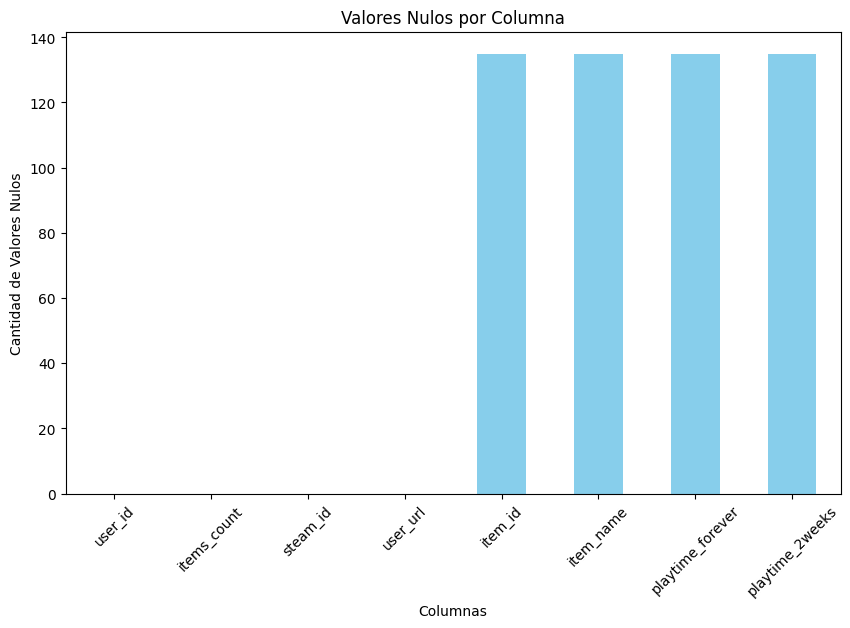

In [33]:
# Crear un DataFrame que contenga información sobre los valores nulos
null_counts = df_user_items_explode.isnull().sum()

# Filtrar las columnas de interés
columns_of_interest = ['user_id', 'items_count', 'steam_id', 'user_url', 'item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']
null_counts = null_counts[columns_of_interest]

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Valores Nulos por Columna')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


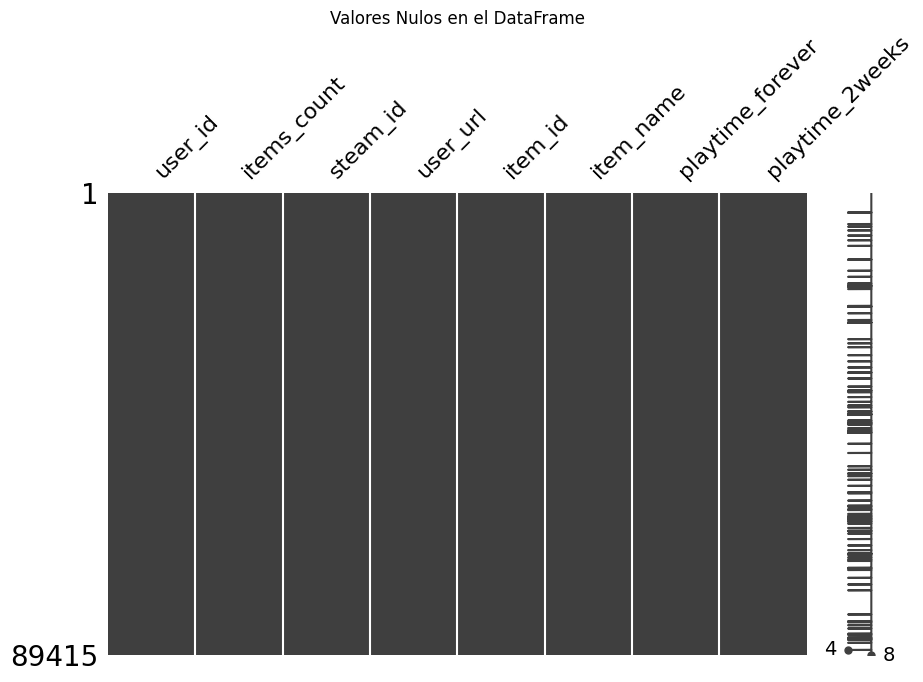

In [34]:
# Visualizar valores nulos de otra manera para ver la distribución
msno.matrix(df_user_items_explode, figsize=(10, 6))

# Añadir un título al gráfico
plt.title('Valores Nulos en el DataFrame')

# Mostrar el gráfico
plt.show()
# Este código utiliza la función msno.matrix para crear una visualización de matriz que muestra los valores nulos en tu DataFrame df_user_items_explode. Los espacios en blanco en la matriz representan los valores nulos. Asegúrate de tener matplotlib instalado para mostrar el gráfico. Esta visualización puede ayudarte a identificar las columnas con valores nulos de manera efectiva.

In [35]:
# Ahora eliminaremos las columnas innecesarias
columns_to_drop = ['steam_id', 'user_url', 'items_count', 'playtime_2weeks']

# Utilizaremos el método drop para eliminar las columnas
df_user_items_explode = df_user_items_explode.drop(columns=columns_to_drop)


In [36]:
# Veamos nuevamente
df_user_items_explode

,user_id,item_id,item_name,playtime_forever
0,76561197970982479,10,Counter-Strike,6.0
1,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,30,Day of Defeat,7.0
3,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...
89410,aquelecaraqfazaquilo,359550,Tom Clancy's Rainbow Six Siege,503.0
89411,aquelecaraqfazaquilo,433340,Slime Rancher,33.0
89412,aquelecaraqfazaquilo,466910,Worm.is: The Game,60.0
89413,aquelecaraqfazaquilo,273350,Evolve Stage 2,247.0


In [37]:
# Verifiquemos si hay valores nulos. Como se puede observar, existen varios valores nulos en 3 columnas y puede traernos problemas para operar.
df_user_items_explode.isnull().sum()

user_id               0
item_id             135
item_name           135
playtime_forever    135
dtype: int64

In [38]:
# Eliminar filas con valores nulos en el DataFrame df_user_items_explode
df_user_items_explode.dropna(inplace=True)

In [39]:
# Verifiquemos nuestro dataframe sin valores nulos:
df_user_items_explode.isnull().sum()

user_id             0
item_id             0
item_name           0
playtime_forever    0
dtype: int64

In [40]:
# Ahora veamos si existen datos duplicados
df_user_items_explode.duplicated().sum()

0

In [41]:
# Ahora procedemos a convertir el archivo a csv
df_user_items_explode.to_csv('df_user_items_explode.csv')

In [42]:
# Descargamos el archivo:
files.download('df_user_items_explode.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***EXTRACCIÓN DE DATOS: STEAM_GAMES***

In [43]:
# Creamos una función para poder abrir el archivo steam_games
def abrir_comprimido(archivo):
    data_list = []
    with gzip.open(archivo, 'rt', encoding='utf-8') as file:
        for line in file:
            try:
                data = json.loads(line.strip())
                data_list.append(data)
            except json.JSONDecodeError as e:
                print(f"Error en línea: {line.strip()}")
                print(e)
    return data_list

In [44]:
# Creamos un DataFrame para steam_games
archivo = 'steam_games.json.gz'
data = abrir_comprimido(archivo)
df_steam_games = pd.DataFrame(data)

In [45]:
# Visualizamos las 8 primeras filas para ver el archivo
df_steam_games.head(8)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A simple vista podemos observar la gran cantidad de datos nulos que existen en el archivo.

In [46]:
# Veamos la información general
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


***ETL: Verificaremos valores nulos en cada columna***

In [47]:
# Veamos si existen valores nulos en cada columna y sumemos cada uno
df_steam_games.isnull().sum()

publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89687
early_access    88310
id              88312
developer       91609
dtype: int64

Valores nulos por columna:
publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89687
early_access    88310
id              88312
developer       91609
dtype: int64
Porcentaje de valores nulos por columna:
publisher       80.004982
genres          76.045498
app_name        73.321433
title           75.021794
url             73.319773
release_date    75.035909
tags            73.455104
reviews_url     73.321433
specs           73.876043
price           74.463033
early_access    73.319773
id              73.321433
developer       76.058782
dtype: float64


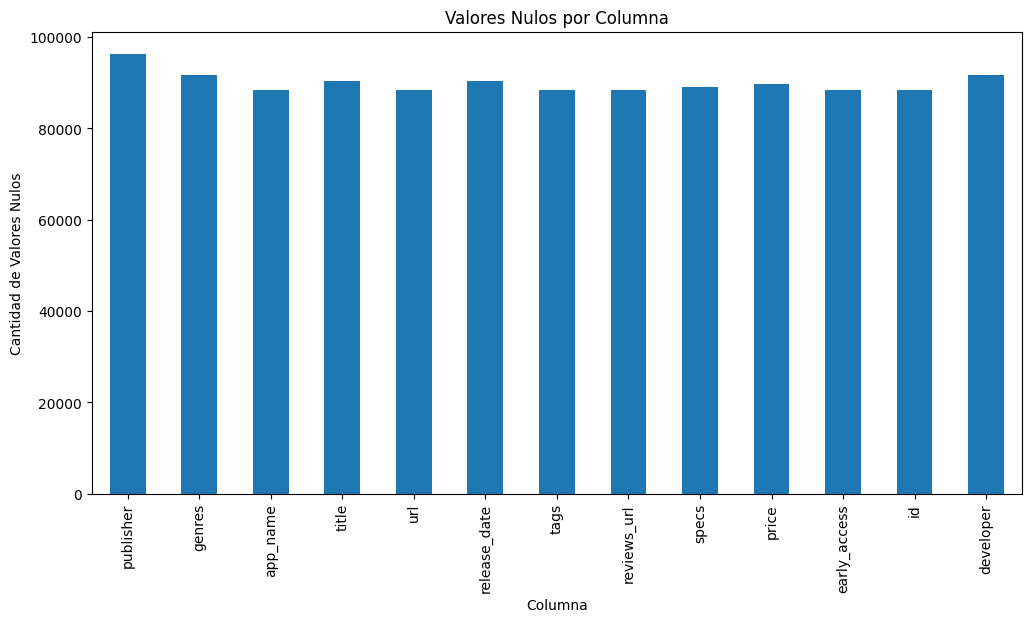

In [48]:
# Definimos una función para visualizar los valores nulos y observemos el % de cada columna:

def visualizar_valores_nulos(df):
    # Generar un DataFrame de booleanos donde True representa valores nulos
    valores_nulos = df.isnull()

    # Contar los valores nulos en cada columna
    nulos_por_columna = valores_nulos.sum()

    # Imprimir el número de valores nulos en cada columna
    print("Valores nulos por columna:")
    print(nulos_por_columna)

    # Imprimir el porcentaje de valores nulos en cada columna
    porcentaje_nulos_por_columna = (nulos_por_columna / len(df)) * 100
    print("Porcentaje de valores nulos por columna:")
    print(porcentaje_nulos_por_columna)

    # Crear un gráfico de barras de valores nulos
    plt.figure(figsize=(12, 6))
    nulos_por_columna.plot(kind='bar')
    plt.title('Valores Nulos por Columna')
    plt.xlabel('Columna')
    plt.ylabel('Cantidad de Valores Nulos')
    plt.show()

# Utiliza la función para visualizar valores nulos en df_steam_games
visualizar_valores_nulos(df_steam_games)


In [49]:
# Eliminamos y limpiamos los valores nulos y le damos un nuevo nombre al archivo sin valores nulos:
df_steam_games_clean = df_steam_games.dropna()

In [50]:
# Chequeamos la info luego de la limpeza:
df_steam_games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22530 entries, 88310 to 120443
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     22530 non-null  object
 1   genres        22530 non-null  object
 2   app_name      22530 non-null  object
 3   title         22530 non-null  object
 4   url           22530 non-null  object
 5   release_date  22530 non-null  object
 6   tags          22530 non-null  object
 7   reviews_url   22530 non-null  object
 8   specs         22530 non-null  object
 9   price         22530 non-null  object
 10  early_access  22530 non-null  object
 11  id            22530 non-null  object
 12  developer     22530 non-null  object
dtypes: object(13)
memory usage: 2.4+ MB


In [51]:
# Observamos que hay columnas que no son relevantes para éste caso, entonces decidimos eliminarlas
# Lista de columnas a eliminar
columnas_a_eliminar = ['publisher', 'tags', 'reviews_url', 'specs', 'early_access', 'url', 'price', 'developer']

# Elimina las columnas de la lista
df_steam_games_clean = df_steam_games_clean.drop(columnas_a_eliminar, axis=1)

# Ahora df_steam_games_clean contendrá las columnas restantes

In [52]:
# Ahora veamos cómo quedaría
df_steam_games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22530 entries, 88310 to 120443
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        22530 non-null  object
 1   app_name      22530 non-null  object
 2   title         22530 non-null  object
 3   release_date  22530 non-null  object
 4   id            22530 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [53]:
df_steam_games_clean

,genres,app_name,title,release_date,id
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,761140
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,643980
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,670290
88313,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,767400
88315,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,2018-01-04,772540
...,...,...,...,...,...
120439,"[Action, Adventure, Casual, Indie]",Kebab it Up!,Kebab it Up!,2018-01-04,745400
120440,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,2018-01-04,773640
120441,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,2018-01-04,733530
120442,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,2018-01-04,610660


Podemos observar que la columna "app_name" y "title" comparten información, por lo que visualizaremos y concatenaremos ambas columas para explorar la información que contienen.

In [54]:
# Seleccionar las columnas 'app_name' y 'title' y concatenarlas en un nuevo DataFrame
info_columnas = pd.concat([df_steam_games_clean['app_name'], df_steam_games_clean['title']], axis=1)

# Imprimir las primeras filas del nuevo DataFrame
print(info_columnas.head())


                      app_name                    title
88310      Lost Summoner Kitty      Lost Summoner Kitty
88311                Ironbound                Ironbound
88312  Real Pool 3D - Poolians  Real Pool 3D - Poolians
88313                  弹炸人2222                  弹炸人2222
88315    Battle Royale Trainer    Battle Royale Trainer


In [55]:
# Crearemos una nueva columna llamada 'game' que contiene la información de 'app_name', 'title' y eliminaremos las columnas anteriores para estandarizar datos:
df_steam_games_clean['game_name'] = df_steam_games_clean['app_name'] + ' - ' + df_steam_games_clean['title']

# Eliminar las columnas 'app_name' y 'title'
df_steam_games_clean.drop(['app_name', 'title'], axis=1, inplace=True)

In [56]:
# Imprimir las primeras filas del DataFrame actualizado
display(df_steam_games_clean)

,genres,release_date,id,game_name
88310,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,761140,Lost Summoner Kitty - Lost Summoner Kitty
88311,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,643980,Ironbound - Ironbound
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,670290,Real Pool 3D - Poolians - Real Pool 3D - Poolians
88313,"[Action, Adventure, Casual]",2017-12-07,767400,弹炸人2222 - 弹炸人2222
88315,"[Action, Adventure, Simulation]",2018-01-04,772540,Battle Royale Trainer - Battle Royale Trainer
...,...,...,...,...
120439,"[Action, Adventure, Casual, Indie]",2018-01-04,745400,Kebab it Up! - Kebab it Up!
120440,"[Casual, Indie, Simulation, Strategy]",2018-01-04,773640,Colony On Mars - Colony On Mars
120441,"[Casual, Indie, Strategy]",2018-01-04,733530,LOGistICAL: South Africa - LOGistICAL: South A...
120442,"[Indie, Racing, Simulation]",2018-01-04,610660,Russian Roads - Russian Roads


In [57]:
df_steam_games_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22530 entries, 88310 to 120443
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        22530 non-null  object
 1   release_date  22530 non-null  object
 2   id            22530 non-null  object
 3   game_name     22530 non-null  object
dtypes: object(4)
memory usage: 880.1+ KB


In [58]:
# Eliminaremos las listas de la columna "genres" y transformaremos los datos a cadenas de texto
columna_genres = 'genres'

# Convierte las listas a cadenas y elimina los corchetes
df_steam_games_clean[columna_genres] = df_steam_games_clean[columna_genres].apply(lambda x: ', '.join(x) if x else None)

In [59]:
# Ahora procedemos a convertir el archivo a csv
df_steam_games_clean.to_csv('df_steam_games_clean.csv')

In [60]:
# Descargamos el archivo:
files.download('df_steam_games_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1° Función: "*def PlayTimeGenre*"




In [61]:
# Creamos una nueva columna para el df_steam_games_clean y asignamos los valores de la columna "id" a la columna recién creada "item_id", lo que significa
# que ahora tendr una columna duplicada con los mismos valores que la columna original "id"
df_steam_games_clean["item_id"] = df_steam_games_clean["id"]

# Borramos la columna que no necesitamos
df_steam_games_clean.drop(columns=["id"],inplace=True)

In [62]:
# Hacemos una intersección entre los df y creamos una variable llamada tabla
tabla=pd.merge(df_steam_games_clean,df_user_items_explode,on="item_id", how="inner")

In [63]:
# Extraemos el año de la columna release_date y creamos una nueva llamada "year":

# Convierte la columna 'release_date' a formato de fecha y extrae el año
tabla['year'] = pd.to_datetime(tabla['release_date']).dt.year

# Elimina la columna 'release_date'
tabla.drop('release_date', axis=1, inplace=True)


In [64]:
# Veamos si existen valores nulos
tabla.isnull().sum()

genres              0
game_name           0
item_id             0
user_id             0
item_name           0
playtime_forever    0
year                0
dtype: int64

In [65]:
# Como podemos observar, no existen valores nulos, por lo tanto, veamos si existen valores duplicados.
tabla.duplicated().sum()

0

In [66]:
# Eliminaremos las columnas que no nos sirvan, cambiaremos algunos formatos para reducir el espacio y eliminaremos valores duplicados para poder optimizar el dataframe.

# Cambiamos tipos de datos
tabla['year'] = tabla['year'].astype('int32')
tabla['playtime_forever'] = tabla['playtime_forever'].astype('float32')

# Eliminar filas duplicadas en todo el DataFrame
tabla.drop_duplicates()

,genres,game_name,item_id,user_id,item_name,playtime_forever,year
0,"Action, Indie, Racing",Carmageddon Max Pack - Carmageddon Max Pack,282010,UTNerd24,Carmageddon Max Pack,5.0,1997
1,"Action, Indie, Racing",Carmageddon Max Pack - Carmageddon Max Pack,282010,I_DID_911_JUST_SAYING,Carmageddon Max Pack,0.0,1997
2,"Action, Indie, Racing",Carmageddon Max Pack - Carmageddon Max Pack,282010,76561197962104795,Carmageddon Max Pack,0.0,1997
3,"Action, Indie, Racing",Carmageddon Max Pack - Carmageddon Max Pack,282010,r3ap3r78,Carmageddon Max Pack,0.0,1997
4,"Action, Indie, Racing",Carmageddon Max Pack - Carmageddon Max Pack,282010,saint556,Carmageddon Max Pack,13.0,1997
...,...,...,...,...,...,...,...
70002,Action,Counter-Strike: Condition Zero - Counter-Strik...,80,C14M8S,Counter-Strike: Condition Zero,204.0,2004
70003,Action,Counter-Strike: Condition Zero - Counter-Strik...,80,1122305938,Counter-Strike: Condition Zero,1.0,2004
70004,Action,Counter-Strike: Condition Zero - Counter-Strik...,80,Cabjoy,Counter-Strike: Condition Zero,0.0,2004
70005,Action,Counter-Strike: Condition Zero - Counter-Strik...,80,76561198045679186,Counter-Strike: Condition Zero,0.0,2004


In [67]:
tabla.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70007 entries, 0 to 70006
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            70007 non-null  object 
 1   game_name         70007 non-null  object 
 2   item_id           70007 non-null  object 
 3   user_id           70007 non-null  object 
 4   item_name         70007 non-null  object 
 5   playtime_forever  70007 non-null  float32
 6   year              70007 non-null  int32  
dtypes: float32(1), int32(1), object(5)
memory usage: 3.7+ MB


In [68]:
# Eliminaremos columnas que no necesitamos para la función:
tabla.drop(['game_name','item_id'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
# filtramos los datos con el género "Action"
mask=tabla['genres'].apply(lambda x: 'Action' in x)
tabla[mask][['year','playtime_forever']]

In [ ]:
display(tabla)

In [ ]:
# Guardar el DataFrame en un nuevo archivo
tabla.to_csv('tabla.csv', index=False)

In [ ]:
# Descargamos el archivo:
files.download('tabla.csv')

In [ ]:
# Definimos la función para saber la cantidad de horas jugadas para cada género:

def PlayTimeGenre(genre: str):
    # Filtrar por el género especificado
    genre_df = tabla[tabla['genres'].str.contains(genre, case=False, na=False)].head(10000)

    # Encontrar el año con más horas jugadas para ese género
    max_playtime_year = genre_df.groupby('year')['playtime_forever'].sum().idxmax()

    return {'genre': genre, 'max_playtime_year': int(max_playtime_year)}

In [ ]:
# Llamada a la función con el género 'Action' para probarla
genre = 'Action'
result = PlayTimeGenre(genre)
print(result)

## 2° Función: "*def UserForGenre*"



In [ ]:
# PRUEBA 1

In [69]:
import pandas as pd

def UserForGenre(genre: str, tabla):
    max_playtime_users = pd.DataFrame(columns=['genres', 'user_id', 'max_playtime'])

    genre_data = tabla[tabla['genres'] == genre]
    max_playtime = genre_data.groupby('user_id')['playtime_forever'].sum().max()
    user_max_playtime = genre_data.groupby('user_id')['playtime_forever'].sum().idxmax()

    max_playtime_users = max_playtime_users.append({'genres': genre, 'user_id': user_max_playtime, 'max_playtime': max_playtime}, ignore_index=True)

    output_dict = {
        genre: {
            'user_id': max_playtime_users['user_id'].values[0],
            'max_playtime': max_playtime_users['max_playtime'].values[0]
        }
    }

    return output_dict


In [70]:
# Llamada a la función UserForGenre
resultado = UserForGenre('Action', tabla)
print(resultado)

{'Action': {'user_id': '76561198016685643', 'max_playtime': 441716.0}}


## 3° Función: "*def UsersRecommend*"

In [71]:
# Sacaremos un muestra de un % de datos del dataframe para asegurarnos el óptimo funcionamiento:
# Tomar una muestra aleatoria del 25% con random_state=22
#df_muestra = df_user_reviews_final.sample(frac=0.25, random_state=22)

In [72]:
df_user_reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 2453
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             1927 non-null   object        
 1   item_id             1927 non-null   object        
 2   recommend           1927 non-null   object        
 3   fecha               1927 non-null   datetime64[ns]
 4   sentiment_analysis  1927 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 90.3+ KB


In [73]:
# Convertir la columna 'item_id' a formato entero
df_user_items_explode['item_id'] = df_user_items_explode['item_id'].astype(int)
df_user_reviews_final['item_id'] = df_user_reviews_final['item_id'].astype(int)

In [80]:
def UsersRecommend(year: int):

    # Convertir la columna 'fecha' a datetime si no está en ese formato
    df_user_reviews_final['fecha'] = pd.to_datetime(df_user_reviews_final['fecha'], errors='coerce')

    # Filtrar por el año especificado
    df_specific_year = df_user_reviews_final[df_user_reviews_final['fecha'].dt.year == year]

    # Filtrar por recomendaciones positivas
    df_recomendados = df_specific_year[df_specific_year['recommend'] == True]

    # Obtener los tres juegos más recomendados
    df_recomendados_merged = df_recomendados.merge(df_user_items_explode[['item_id', 'item_name']], on='item_id', how='inner')
    top3_games = df_recomendados_merged['item_name'].value_counts().head(3)

    # Convertir el resultado a un formato de lista de diccionarios
    resultado = [{'Puesto ' + str(i + 1): juego} for i, juego in enumerate(top3_games.index)]

    return resultado


***Prueba***

In [81]:
# Llama a la función con el año que deseas analizar
resultados = UsersRecommend(2013)  # Cambia el año según tus necesidades

# Imprime los resultados para revisarlos
print(resultados)


[{'Puesto 1': 'Left 4 Dead 2'}, {'Puesto 2': "Garry's Mod"}, {'Puesto 3': 'Counter-Strike: Global Offensive'}]


## 4° Función: "*def UserNotRecommend*"

In [89]:
def UsersNotRecommend(year: int):

    # Convertir la columna 'fecha' a datetime si no está en ese formato
    df_user_reviews_final['fecha'] = pd.to_datetime(df_user_reviews_final['fecha'], errors='coerce')

    # Filtrar por el año especificado
    df_specific_year = df_user_reviews_final[df_user_reviews_final['fecha'].dt.year == year]

    # Filtrar por recomendaciones negativas
    df_no_recomendados = df_specific_year[df_specific_year['recommend'] == False]

    # Obtener los tres juegos menos recomendados
    df_no_recomendados_merged = df_no_recomendados.merge(df_user_items_explode[['item_id', 'item_name']], on='item_id', how='inner')
    bottom3_games = df_no_recomendados_merged['item_name'].value_counts().head(3)

    # Convertir el resultado a un formato de lista de diccionarios
    resultado = [{'Puesto ' + str(i + 1): juego} for i, juego in enumerate(bottom3_games.index)]

    return resultado


In [90]:
# Llama a la función con el año que deseas analizar
year = 2013
resultado = UsersNotRecommend(year)
# Imprime el resultado
print(resultado)


[{'Puesto 1': 'F.E.A.R. 3'}, {'Puesto 2': 'StarForge'}, {'Puesto 3': 'Sniper Ghost Warrior 2'}]


## 5° Función: "*def sentiment_analysis*"

In [102]:
def Sentiment_analysis(year: int):

    # Convertir la columna 'fecha' a datetime si no está en ese formato
    df_user_reviews_final['fecha'] = pd.to_datetime(df_user_reviews_final['fecha'], errors='coerce')

    # Filtrar por el año especificado
    df_year = df_user_reviews_final[df_user_reviews_final['fecha'].dt.year == year]

    if df_year.empty:
        return {"error": "No hay datos para el año proporcionado"}

    # Contar la cantidad de registros por análisis de sentimiento
    sentiment_counts = df_year['sentiment_analysis'].value_counts().reset_index()
    sentiment_counts.rename(columns={'index': 'Sentimiento', 'sentiment_analysis': 'Cantidad'}, inplace=True)

    # Convertir el DataFrame a un diccionario
    result = sentiment_counts.to_dict()

    return result


In [103]:
# Llama a la función con el año que deseas analizar
year = 2012
resultado = Sentiment_analysis(year)

# Imprime el resultado
print(resultado)


{'Sentimiento': {0: 2, 1: 1, 2: 0}, 'Cantidad': {0: 35, 1: 16, 2: 6}}


## 6° Función: "*def recomendacion_juego( id de producto )*"

In [104]:
df_games = df_steam_games_clean.set_index('game_name')

In [105]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22530 entries, Lost Summoner Kitty - Lost Summoner Kitty to EXIT 2 - Directions - EXIT 2 - Directions
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        22530 non-null  object
 1   release_date  22530 non-null  object
 2   item_id       22530 non-null  object
dtypes: object(3)
memory usage: 704.1+ KB


In [109]:
# EDA: al desanidar la columna genres, el archivo se expande debido a la cantidad de carácteres contenidos en el mismo, por lo tanto, tomaremos una muestra para optimizar la función
df_games = df_games.sample(frac=0.8, random_state=24)

In [107]:
df_games

,genres,release_date,item_id
game_name,,,
EURGAVA™ - Fight for Haaria - EURGAVA™ - Fight for Haaria,"Casual, Indie, RPG, Strategy",2016-12-01,559350
Elegy for a Dead World - Elegy for a Dead World,"Adventure, Indie",2014-12-10,252290
Sprinter - Sprinter,"Action, Indie",2016-02-24,442260
Keyboard Killers - Keyboard Killers,"Action, Casual, Indie, Simulation",2017-09-21,699240
The Francy Droo & Friends Collection - The Francy Droo &amp; Friends Collection,"Adventure, Casual, Indie",2017-12-05,734890
...,...,...,...
rooMaze - rooMaze,"Action, Adventure, Indie, RPG",2017-03-03,575830
FSX Steam Edition: Robinson R44 Add-On - FSX Steam Edition: Robinson R44 Add-On,Simulation,2017-07-19,602811
Botanicula - Botanicula,"Adventure, Casual, Indie",2012-05-07,207690


In [110]:
# Dividir los valores separados por comas en columnas individuales
split_genres = df_games['genres'].str.get_dummies(',')

In [111]:
display(split_genres)

,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,Education,Free to Play,Indie,...,Indie,Massively Multiplayer,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Web Publishing
game_name,,,,,,,,,,,,,,,,,,,,,
Pyramid Raid - Pyramid Raid,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Kennedy and Kitchens Spotter Audio - Kennedy and Kitchens Spotter Audio,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Mafia II DLC: Greaser Pack - Mafia II DLC: Greaser Pack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Call of Duty®: Advanced Warfare - Creature Personalization Pack - Call of Duty®: Advanced Warfare - Creature Personalization Pack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Wild Animals - Animated Jigsaws - Wild Animals - Animated Jigsaws,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Reigns: Her Majesty Soundtrack - Reigns: Her Majesty Soundtrack,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ICARUS.1 - ICARUS.1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Depths of Fear :: Knossos - Depths of Fear :: Knossos,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [112]:
Similitud_coseno = cosine_similarity(split_genres.values)
Similitud_coseno

array([[1.        , 0.        , 0.57735027, ..., 0.66666667, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.57735027, 0.        , 1.        , ..., 0.57735027, 0.        ,
        0.        ],
       ...,
       [0.66666667, 0.        , 0.57735027, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ]])

In [113]:
# Convierto el array en un Dataframe:
df_simil_coseno = pd.DataFrame(Similitud_coseno, index = split_genres.index, columns = split_genres.index)

In [ ]:
# Veamos
df_simil_coseno

In [115]:
# Ahora cambio los nombres de los juegos por sus respectivos ID:
df_simil_coseno.columns = df_games["item_id"]

In [116]:
# Veamos de nuevo como queda
df_simil_coseno

item_id,386510,561812,67330,331062,545960,340270,346650,410530,320382,34319,...,254440,362980,18120,38180,209000,759680,395470,252570,73013,500218
game_name,,,,,,,,,,,,,,,,,,,,,
Pyramid Raid - Pyramid Raid,1.000000,0.0,0.577350,0.577350,0.000000,0.408248,0.408248,0.0,0.408248,0.0,...,0.258199,0.333333,0.866025,0.000000,0.408248,0.333333,0.816497,0.666667,0.0,0.0
Kennedy and Kitchens Spotter Audio - Kennedy and Kitchens Spotter Audio,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Mafia II DLC: Greaser Pack - Mafia II DLC: Greaser Pack,0.577350,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.707107,0.0,...,0.000000,0.000000,0.500000,0.000000,0.707107,0.000000,0.707107,0.577350,0.0,0.0
Call of Duty®: Advanced Warfare - Creature Personalization Pack - Call of Duty®: Advanced Warfare - Creature Personalization Pack,0.577350,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.707107,0.0,...,0.000000,0.000000,0.500000,0.000000,0.707107,0.000000,0.707107,0.577350,0.0,0.0
Wild Animals - Animated Jigsaws - Wild Animals - Animated Jigsaws,0.000000,0.0,0.000000,0.000000,1.000000,0.500000,0.500000,0.0,0.000000,0.0,...,0.632456,0.408248,0.000000,0.707107,0.000000,0.816497,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Reigns: Her Majesty Soundtrack - Reigns: Her Majesty Soundtrack,0.333333,0.0,0.000000,0.000000,0.816497,0.816497,0.816497,0.0,0.000000,0.0,...,0.774597,0.666667,0.288675,0.577350,0.000000,1.000000,0.408248,0.333333,0.0,0.0
ICARUS.1 - ICARUS.1,0.816497,0.0,0.707107,0.707107,0.000000,0.500000,0.500000,0.0,0.500000,0.0,...,0.316228,0.408248,0.707107,0.000000,0.500000,0.408248,1.000000,0.816497,0.0,0.0
Depths of Fear :: Knossos - Depths of Fear :: Knossos,0.666667,0.0,0.577350,0.577350,0.000000,0.408248,0.408248,0.0,0.816497,0.0,...,0.258199,0.333333,0.577350,0.000000,0.816497,0.333333,0.816497,1.000000,0.0,0.0


In [117]:
# Verificamos nuevamente el tamaño del df:
df_simil_coseno.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14419 entries, Pyramid Raid - Pyramid Raid to Train Simulator: North Jersey Coast & Morristown Lines Route Add-On - Train Simulator: North Jersey Coast &amp; Morristown Lines Route Add-On
Columns: 14419 entries, 386510 to 500218
dtypes: float64(14419)
memory usage: 1.5+ GB


In [120]:
# Creamos la función:
def recomendacion_game(item_id: str):

    # Obtenemos la columna correspondiente para cada id
    columna_juego = df_simil_coseno[item_id]

    # Obtener los juegos con los mejores puntajes (menores que 1)
    games = columna_juego[columna_juego < 1.0].sort_values(ascending=False).head(5).index.tolist()

    return games

In [121]:
# Probamos la función:
item_id = '487580'
resultados = recomendacion_game(item_id)

print(f"Juegos recomendados similares a ID n°'{item_id}': {resultados}")

Juegos recomendados similares a ID n°'487580': ['History2048 - 3D puzzle number game - History2048 - 3D puzzle number game', 'Save Their Souls - Save Their Souls', 'Awe - Awe', 'Rocksmith - Violent Femmes - Blister in the Sun - Rocksmith - Violent Femmes - Blister in the Sun', 'Tinboy - Tinboy']


In [ ]:
# Guardar el DataFrame en un nuevo archivo csv
df_simil_coseno.to_csv('df_simil_coseno.csv', index=False)

In [ ]:
# Descargamos el archivo:
files.download('df_simil_coseno.csv')